# Transfer View Data from Tableau Server to Google Big Query by Web Scraping

## Agenda

1. Output a view from Tableau server to local CSV
2. Format the data to what we need
3. Upload the CSV to BQ
4. Shortcomings

## 1. Output a view from Tableau server to local CSV

[Target View](https://tableau-scm.homedepot.com/#/views/OOSRCBPSonly/OOSRCBPSonly?:iid=1)

**Step 0**.

Ask Cheryl on Slack to get your Tableau Server password (User id should be your Email)

![title](slack.png)

Change the password to a secure one on Tableau Server.

![title](changepassword.png)
[Tableau Server](https://tableau-scm.homedepot.com/#/user/local/Feifan_Gu@homedepot.com/settings)

**Step 1**. 

Log on to the server

In [2]:
import tableauserverclient as TSC
import warnings
warnings.filterwarnings("ignore")
# type in your username and password
tableau_auth = TSC.TableauAuth('feifan_gu@homedepot.com', 'yourpasswordhere')
# type in the server you are trying to log on
server = TSC.Server('https://tableau-scm.homedepot.com/')
server.add_http_options({'verify': False})
server.auth.sign_in(tableau_auth)
server.version = '3.7'

In [61]:
s_info = server.server_info.get()
print("\nServer info:")
print("\tProduct version: {0}".format(s_info.product_version))
print("\tREST API version: {0}".format(s_info.rest_api_version))
print("\tBuild number: {0}".format(s_info.build_number))



Server info:
	Product version: 2020.1.6
	REST API version: 3.7
	Build number: 20201.20.0626.1424


 In the TSC.TableauAuth() command, you may or may not pass the site name as the third parameter. If on the SCM environment, there's only the Default site, for that you leave the site name out of the parameters; If on other servers, you should check with Cheryl if there are multiple sites, if so, you should pass the one that you are looking into as the third parameter.

In [76]:
with server.auth.sign_in(tableau_auth):
    for st in TSC.Pager(server.sites):
        print(st.name)

Default


Also, you should pass the correct server.version. (We use 2.8 for the SCM server)

REST API version | Tableau Server version
---|:---------:
3.8	| 2020.2
3.7	|2020.1
3.6	|2019.4
3.5	|2019.3
3.4	|2019.2
3.3	|2019.1
3.2	|2018.3
3.1	|2018.2
3.0	|2018.1
2.8	|10.5
2.7	|10.4
2.6	|10.3
2.5	|10.2
2.4	|10.1
2.3	|10.0

**Step 2**. 

Find the view and download its data as CSV

[TSC Document](https://tableau.github.io/server-client-python/docs/)

_Method 1_.

Get all the view names; find the position of our target view name amoung these view names; get all the views, output the target view using the position we just found.

In [5]:
# get all the view names
name_list = [] 

with server.auth.sign_in(tableau_auth):
    for view in TSC.Pager(server.views):
        #print(view.name)
        name_list.append(view.name)
print(name_list[-10:-1])

['Delivery Sub-Category Score', 'OMS ID - Open Order Detail', 'hit date', 'INB PO Details', 'Network OB Trending Chart', 'Review Table   ', 'Open Orders Past MSBD - Vendor Summary', 'Vendor - DFM Mapping', 'All-Time Highs vs Current Day']


In [6]:
def get_index_positions(list_of_elems, element):
    ''' Returns the indexes of all occurrences of give element in
    the list- listOfElements '''
    index_pos_list = []
    index_pos = 0
    while True:
        try:
            # Search for item in list from indexPos to the end of list
            index_pos = list_of_elems.index(element, index_pos)
            # Add the index position in list
            index_pos_list.append(index_pos)
            index_pos += 1
        except ValueError as e:
            break
    return index_pos_list

In [7]:
# make sure the view exists and find the location
# if mutiple views are detected in this step, download the image/csv to locate the one that you need
index_pos_list = get_index_positions(name_list, 'OOS RC BPS only')
index_pos_list

[3333]

In [8]:
# retreive the view files
view_list = [] 

with server.auth.sign_in(tableau_auth):
    for view in TSC.Pager(server.views):
        view_list.append(view) 

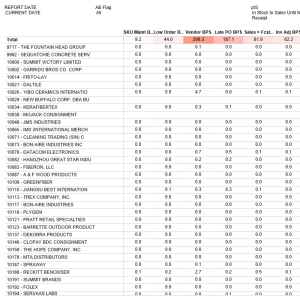

In [9]:
# check the thumbnail image to see if it is what we need
from PIL import Image
with server.auth.sign_in(tableau_auth):
    server.views.populate_preview_image(view_list[index_pos_list[0]])
    with open('./view_preview_image.png', 'wb') as f:
        f.write(view_list[index_pos_list[0]].preview_image)

im = Image.open('view_preview_image.png')
im

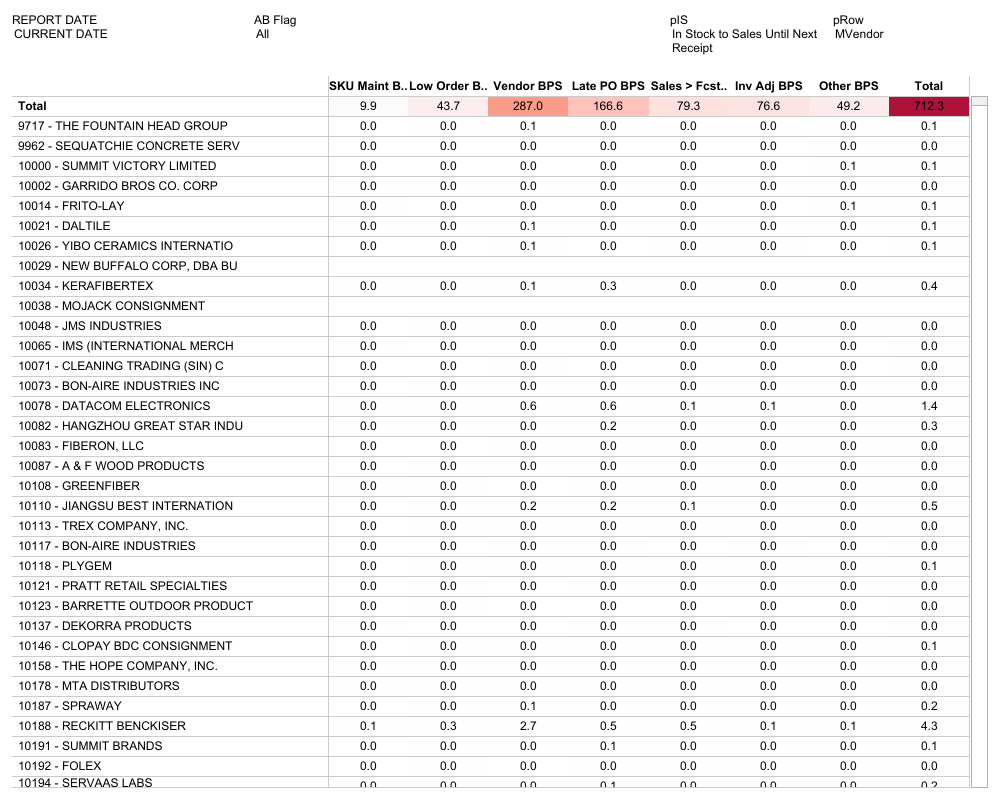

In [81]:
# check the image of the view to see if it is what we need
from PIL import Image
with server.auth.sign_in(tableau_auth):
    server.views.populate_image(view_list[index_pos_list[0]])
    with open('./view_image.png', 'wb') as f:
        f.write(view_list[index_pos_list[0]].image)

im = Image.open('view_image.png')
im

In [10]:
# output the view data as csv file
    server.views.populate_csv(view_list[index_pos_list[0]])
    filename = './BPS_M1.csv'
    with open(filename, 'wb') as f:
        f.write(b''.join(view_list[index_pos_list[0]].csv))
            
# for i in range(len(index_pos_list)):
#     with server.auth.sign_in(tableau_auth):
#         server.views.populate_csv(view_list[index_pos_list[i]])
#         filename = './BPS '+str(i)+'.csv'
#         with open(filename, 'wb') as f:
#             f.write(b''.join(view_list[index_pos_list[i]].csv))

_Method 2_. 

Use filter option to directly download the target view

view 0


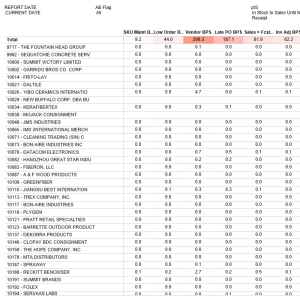

In [3]:
from IPython.display import Image, display
with server.auth.sign_in(tableau_auth):
    req_option = TSC.RequestOptions()
    req_option.filter.add(TSC.Filter(TSC.RequestOptions.Field.Name,
                                 TSC.RequestOptions.Operator.Equals,
                                 'OOS RC BPS only'))
    matching_views, pagination_item = server.views.get(req_option)
    for i in range(len(matching_views)):
        server.views.populate_preview_image(matching_views[i])
        filename = './preview_image '+str(i)+'.png'
        with open(filename, 'wb') as f:
            f.write(matching_views[i].preview_image)
            print('view '+str(i))
            display(Image(filename=filename))
            

view 0


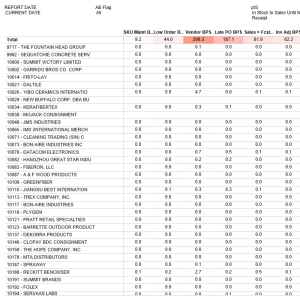

In [25]:
from IPython.display import Image, display
with server.auth.sign_in(tableau_auth):
    req_option = TSC.RequestOptions()
    req_option.filter.add(TSC.Filter(TSC.RequestOptions.Field.Name,
                                 TSC.RequestOptions.Operator.Equals,
                                 'OOS RC BPS only'))
    for i,view in enumerate(TSC.Pager(server.views,req_option)):
        server.views.populate_preview_image(view)
        filename = './preview_image '+str(i)+'.png'
        with open(filename, 'wb') as f:
            f.write(view.preview_image)
            print('view '+str(i))
            display(Image(filename=filename))
            

In [4]:
# # output the view data as csv file
# with server.auth.sign_in(tableau_auth):
#     server.views.populate_csv(matching_views[0])
#     filename = './BPS.csv'
#     with open(filename, 'wb') as f:
#         f.write(b''.join(matching_views[0].csv))

In [12]:
# output the view data as csv file
with server.auth.sign_in(tableau_auth):
    for view in TSC.Pager(server.views,req_option):
        server.views.populate_csv(view)
        filename = './BPS test.csv'
        with open(filename, 'wb') as f:
            f.write(b''.join(view.csv))

Comparing the execution time of the 2 methods:

Step |Method 1 
---|:---------:
Get view names |5.77s
Get target view position	|0.01s
Get views	|4.81s
Image validation	|0.56s
Output	|22.8s
__Total__ | __33.95s__


Step |Method 2 
---|:---------:
Get target view and image validation	|0.66s
Output	|20.7s
__Total__ | __21.36s__



## 2. Reform the data to what we need

In [31]:
import pandas as pd
import numpy as np
# read and check the raw data
view = pd.read_csv('BPS test.csv')
view.head()

,Measure Names,Row,Row Nbr,Total BPS,Measure Values,OOS_CNT,REPLE_COUNT
0,SKU Maint BPS,9717 - THE FOUNTAIN HEAD GROUP,9717,0.1,0.000000,146,"7,327"
1,Low Order BPS,9717 - THE FOUNTAIN HEAD GROUP,9717,0.1,0.015286,146,"7,327"
2,Vendor BPS,9717 - THE FOUNTAIN HEAD GROUP,9717,0.1,0.075750,146,"7,327"
3,Late PO BPS,9717 - THE FOUNTAIN HEAD GROUP,9717,0.1,0.011270,146,"7,327"
4,Sales > Fcst BPS,9717 - THE FOUNTAIN HEAD GROUP,9717,0.1,0.014129,146,"7,327"


**Step 1**. 

Make columns and rows right

In [27]:
#Rows in Row, Columns in Measure Names, and values in Measure Values(For row we use Row Nbr here)
output = view.iloc[:,[0,2,4]]
output.head()

,Measure Names,Row Nbr,Measure Values
0,SKU Maint BPS,9717,0.000000
1,Low Order BPS,9717,0.015286
2,Vendor BPS,9717,0.075750
3,Late PO BPS,9717,0.011270
4,Sales > Fcst BPS,9717,0.014129


In [39]:
# pivot the table (transform the column with column names to seperate columns)
output_pivot = pd.pivot_table(output, values='Measure Values', index=['Row Nbr'],
                    columns=['Measure Names'], aggfunc=np.sum)
output_pivot = output_pivot.reset_index()
output_pivot = output_pivot.rename_axis(None, axis=1)
output_pivot.head()

,Row Nbr,Inv Adj BPS,Late PO BPS,Low Order BPS,Other BPS,SKU Maint BPS,Sales > Fcst BPS,Total,Vendor BPS
0,10000,0.000000,0.000000,0.000000,0.103579,0.000000,0.000000,0.103579,0.000000
1,10002,0.002327,0.000947,0.000250,0.000000,0.000873,0.003699,0.030837,0.022741
2,10014,0.000000,0.000000,0.000000,0.089031,0.000030,0.000128,0.089189,0.000000
3,10021,0.017361,0.007229,0.004179,0.015386,0.001223,0.033616,0.133625,0.054632
4,10026,0.001297,0.000000,0.000000,0.000000,0.000000,0.000545,0.110221,0.108379


**Step 2**. 

Make sure data is correct

In [36]:
output_pivot.dtypes

Row Nbr              object
Inv Adj BPS         float64
Late PO BPS         float64
Low Order BPS       float64
Other BPS           float64
SKU Maint BPS       float64
Sales > Fcst BPS    float64
Total               float64
Vendor BPS          float64
dtype: object

In [40]:
output_pivot['Total'].sum()

1450.298281143

In [37]:
output_pivot.iloc[:,0].sort_values(ascending = False) 

2697      All
2696     9962
2695    99504
2694     9717
2693    96172
        ...  
4       10026
3       10021
2       10014
1       10002
0       10000
Name: Row Nbr, Length: 2698, dtype: object

In [41]:
output_pivot = output_pivot[output_pivot['Row Nbr'] != 'All']

In [42]:
output_pivot['Total'].sum()

725.149140603

If you download data with numbers >= 1000, the data will have commas, making its type to be string. Then you have to remove the commas, or else BQ cannot know that they are numbers actually.

In [13]:
#output_pivot['$ IMPACT - LATE PO']=output_pivot['$ IMPACT - LATE PO'].replace(',','',regex=True)
#output_pivot['TY OH $']=output_pivot['TY OH $'].replace(',','',regex=True)
#convert_dict={'$ IMPACT - LATE PO':float,'TY OH $':float}
#output_pivot = output_pivot.astype(convert_dict)

**Step 3**. 

Add a column to record the update date

In [43]:
import datetime as dt 
current_dt = dt.datetime.today().strftime("%Y%m%d")
output_pivot['current_dt']=current_dt

In [44]:
output_pivot.head()

,Row Nbr,Inv Adj BPS,Late PO BPS,Low Order BPS,Other BPS,SKU Maint BPS,Sales > Fcst BPS,Total,Vendor BPS,current_dt
0,10000,0.000000,0.000000,0.000000,0.103579,0.000000,0.000000,0.103579,0.000000,20200922
1,10002,0.002327,0.000947,0.000250,0.000000,0.000873,0.003699,0.030837,0.022741,20200922
2,10014,0.000000,0.000000,0.000000,0.089031,0.000030,0.000128,0.089189,0.000000,20200922
3,10021,0.017361,0.007229,0.004179,0.015386,0.001223,0.033616,0.133625,0.054632,20200922
4,10026,0.001297,0.000000,0.000000,0.000000,0.000000,0.000545,0.110221,0.108379,20200922


In [68]:
output_pivot.to_csv('output_bps.csv', index=False)

## Reform the historical data to what we need (Skip)

In [ ]:
view = pd.read_csv('BPS_FW31.csv')
output = view.iloc[:,[0,2,4]]
output_pivot = pd.pivot_table(output, values='Measure Values', index=['Row Nbr'],
                    columns=['Measure Names'], aggfunc=np.sum)
output_pivot = output_pivot.reset_index()
output_pivot = output_pivot.rename_axis(None, axis=1)
output_pivot.iloc[:,0] = output_pivot.iloc[:,0].astype(str)
output_pivot = output_pivot[output_pivot['Row Nbr'] != 'All']

In [123]:
output_pivot['Total'].sum()

792.0391028390001

In [124]:
output_pivot['current_dt']=20200906

In [125]:
output_pivot.head()

,Row Nbr,Inv Adj BPS,Late PO BPS,Low Order BPS,Other BPS,SKU Maint BPS,Sales > Fcst BPS,Total,Vendor BPS,current_dt
0,9717,0.009126,0.047669,0.016604,0.020235,0.000000,0.026552,0.243691,0.123504,20200906
1,9962,0.000000,0.000000,0.000000,0.000948,0.000000,0.000000,0.000948,0.000000,20200906
2,10000,0.000000,0.000000,0.000000,0.112995,0.000000,0.000000,0.112995,0.000000,20200906
3,10002,0.000813,0.000813,0.000123,0.000158,0.000000,0.004507,0.025760,0.019346,20200906
4,10014,0.000000,0.000000,0.000000,0.069536,0.000098,0.000060,0.069694,0.000000,20200906


In [127]:
output_history = pd.concat([output_history, output_pivot])

In [128]:
output_history['Total'].sum()

4160.207821215

In [130]:
output_history.to_csv('output_history.csv', index=False)

## 3. Upload the csv to BQ

![Teams](teams.png)

Run the following code to configure the environment

In [45]:
# !pip install virtualenv
# !virtualenv venv
# !venv\Scripts\activate
# !venv\Scripts\pip.exe install google-api-python-client
# !pip install --upgrade google-api-python-client

In [69]:
import os
import glob
import pandas as pd
from subprocess import Popen
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
import uuid
import time
from datetime import timedelta
from google.cloud import bigquery

In [ ]:
def create_service(svc_type='bigquery'):
    credentials = GoogleCredentials.get_application_default()
    return discovery.build(svc_type, 'v2', credentials=credentials)
filename = "output_history.csv"
bucket = 'fmic_data'#???
gs_uri = 'gs://'+bucket+'/'+filename    
#cmd = 'gsutil -o GSUtil:parallel_composite_upload_threshold=150M cp '+filepath+' '+gs_uri
prcss = Popen(['gsutil','-o','GSUtil:parallel_composite_upload_threshold=150M','cp',"C:/Users/FXG0E8H/OneDrive - The Home Depot/Desktop/OOS/" + "/"+ filename,gs_uri],bufsize=-1,shell=True)
#???
prcss.wait()
 
def create_service(svc_type='bigquery'):
    credentials = GoogleCredentials.get_application_default()
    return discovery.build(svc_type, 'v2', credentials=credentials)
# Construct a BigQuery client object.
 
client = bigquery.Client(project = "analytics-supplychain-thd")
 
# TODO(developer): Set table_id to the ID of the table to create.
table_id = "analytics-supplychain-thd.ABC.OOS_RC_BPS"
 
job_config = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField('Mvendor','STRING'),
        bigquery.SchemaField('Inv_Adj_BPS','FLOAT'),
        bigquery.SchemaField('Late_PO_BPS','FLOAT'),
        bigquery.SchemaField('Low_Order_BPS','FLOAT'),
        bigquery.SchemaField('Other_BPS','FLOAT'),
        bigquery.SchemaField('SKU_Maint_BPS','FLOAT'),
        bigquery.SchemaField('Sales_Fcst_BPS','FLOAT'),
        bigquery.SchemaField('Total','FLOAT'),
        bigquery.SchemaField('Vendor_BPS','FLOAT'),
        bigquery.SchemaField('current_dt','STRING')
    ],
    skip_leading_rows=1
)
uri = "gs://fmic_data/output_history.csv"

In [132]:
load_job = client.load_table_from_uri(
    uri, table_id, job_config=job_config
)  # Make an API request.
 
load_job.result()  # Wait for the job to complete.
 
table = client.get_table(table_id)
print("Loaded {} rows to table {}".format(table.num_rows, table_id))

C:\Users\FXG0E8H\Anaconda3\lib\site-packages\google\auth\_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Loaded 16105 rows to table analytics-supplychain-thd.ABC.OOS_RC_BPS


## 4. Shortcomings

**Let's see an example:**

view 0


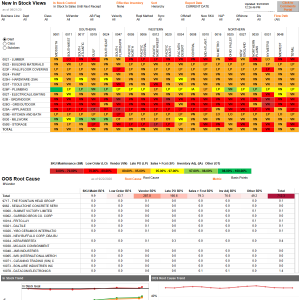

view 1


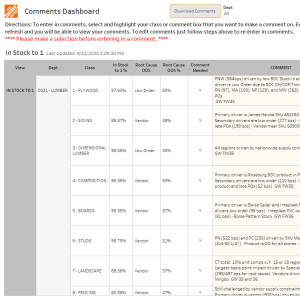

view 2


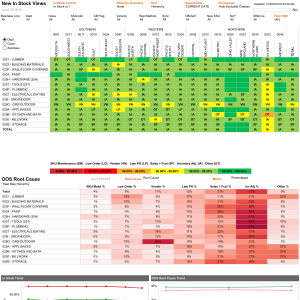

view 3


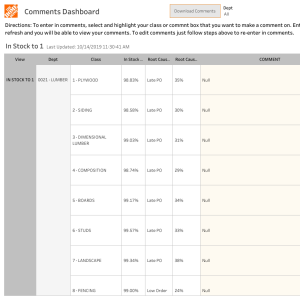

view 4


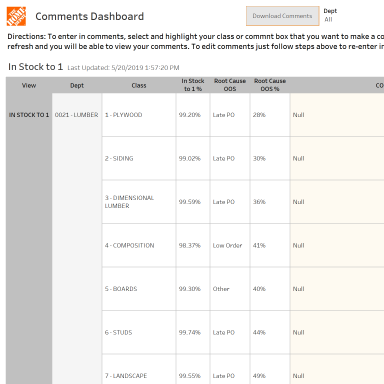

In [26]:
# check the thumbnail images of "Heat Map" views
from IPython.display import Image, display
with server.auth.sign_in(tableau_auth):
    req_option = TSC.RequestOptions()
    req_option.filter.add(TSC.Filter(TSC.RequestOptions.Field.Name,
                                 TSC.RequestOptions.Operator.Equals,
                                 'Heat Map'))
    for i,view in enumerate(TSC.Pager(server.views,req_option)):
        server.views.populate_preview_image(view)
        filename = './preview_image '+str(i)+'.png'
        with open(filename, 'wb') as f:
            f.write(view.preview_image)
            print('view '+str(i))
            display(Image(filename=filename))
            

view 0


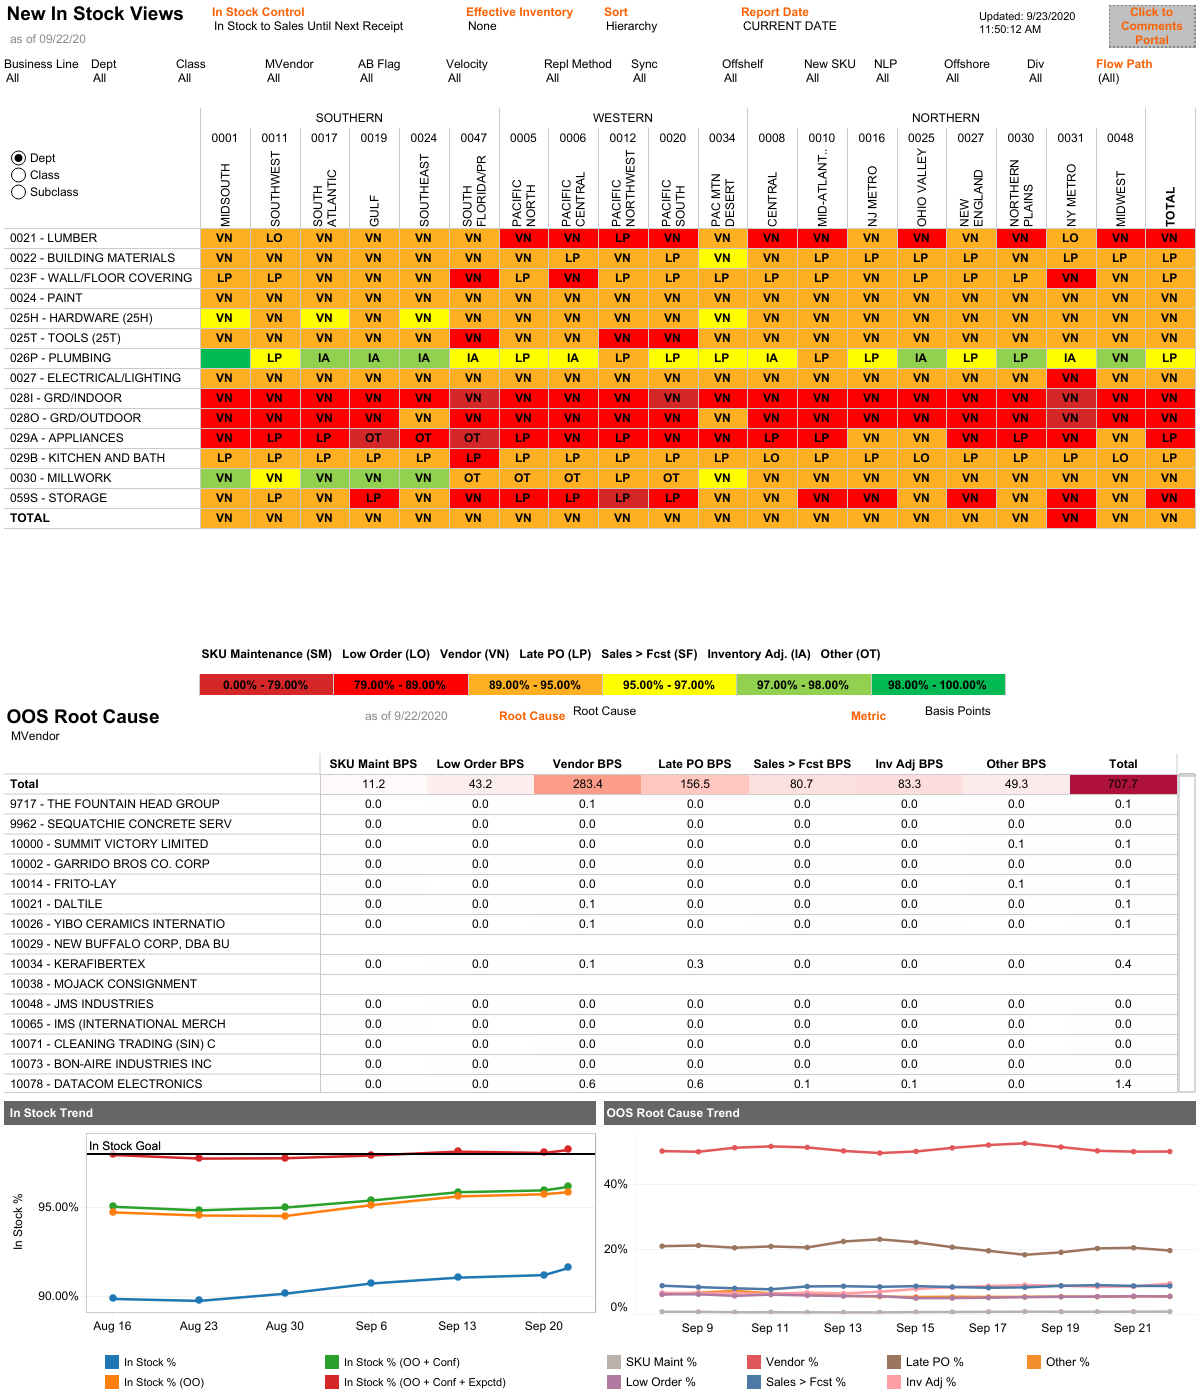

view 2


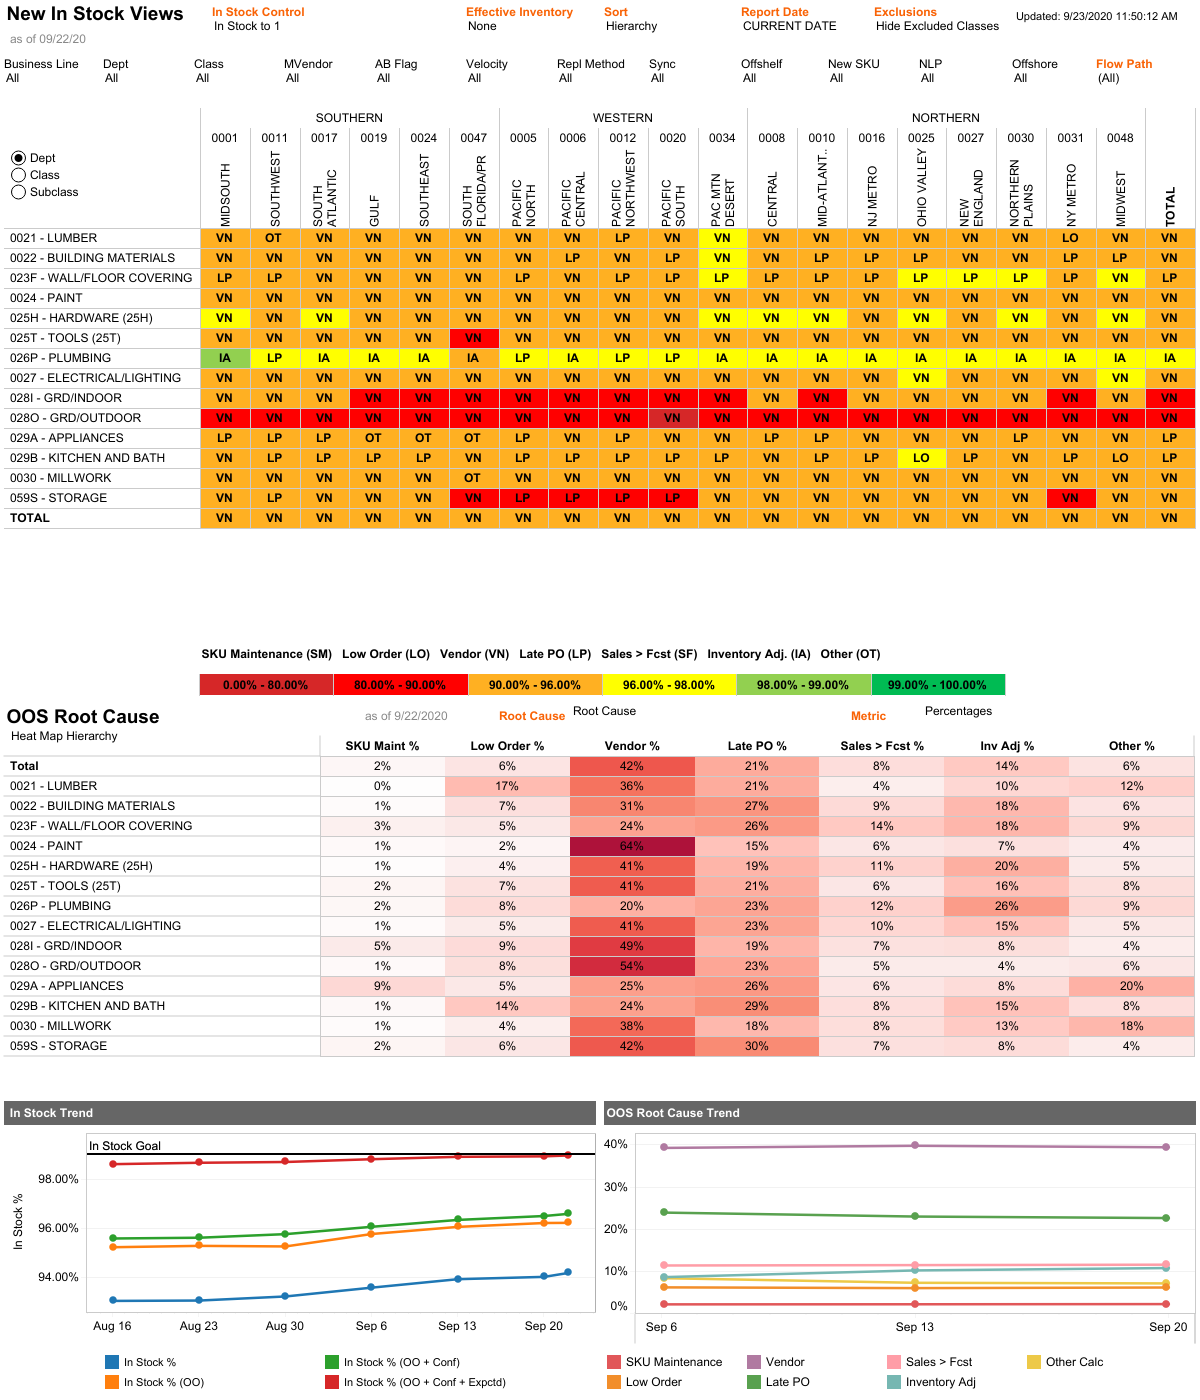

In [29]:
# check the two similar Heat Map views
with server.auth.sign_in(tableau_auth):
    for i,view in enumerate(TSC.Pager(server.views,req_option)):
        if i in [0,2]:
            server.views.populate_image(view)
            filename = './image '+str(i)+'.png'
            with open(filename, 'wb') as f:
                f.write(view.image)
                print('view '+str(i))
                display(Image(filename=filename))

[Heat Map 0](https://tableau-scm.homedepot.com/#/views/NewInStockViews/HeatMap?:iid=1) <br>
[Heat Map 2](https://tableau-scm.homedepot.com/#/views/NewInStockViews_test/HeatMap?:iid=2)

In [28]:
# output the data of the two views as csv file
with server.auth.sign_in(tableau_auth):
    for i,view in enumerate(TSC.Pager(server.views,req_option)):
        if i in [0,2]:
            server.views.populate_csv(view)
            filename = './Heat Map '+str(i)+'.csv'
            with open(filename, 'wb') as f:
                f.write(b''.join(view.csv))

With the Comment Portal Button on the upper right corner, the code can only scrape it, which is rediculous.

In [33]:
view_0 = pd.read_csv('Heat Map 0.csv')
print(view_0)

      Comment Portal Button
0  Click to Comments Portal


Without the Comment Portal Button on the upper right corner, the code can only scrape the data of the first sheet inside the dashboard. 

In [35]:
view_2 = pd.read_csv('Heat Map 2.csv')
print(view_2)

          Div           Hier Hier Sort              Loc Loc Nbr  \
0    SOUTHERN  0021 - LUMBER  21000000         MIDSOUTH    0001   
1    SOUTHERN  0021 - LUMBER  21000000        SOUTHWEST    0011   
2    SOUTHERN  0021 - LUMBER  21000000   SOUTH ATLANTIC    0017   
3    SOUTHERN  0021 - LUMBER  21000000             GULF    0019   
4    SOUTHERN  0021 - LUMBER  21000000        SOUTHEAST    0024   
..        ...            ...       ...              ...     ...   
295  NORTHERN            All       All      NEW ENGLAND    0027   
296  NORTHERN            All       All  NORTHERN PLAINS    0030   
297  NORTHERN            All       All         NY METRO    0031   
298  NORTHERN            All       All          MIDWEST    0048   
299       All            All       All              All     All   

    Calc Highlight  IS Final  OOS RSN Long OOS RSN Map  Sort Calc CLASS  \
0           ORANGE  0.954967  Vendor - 30%          VN        NaN     *   
1           ORANGE  0.952440   Other - 27%   

**Conclusion: Only keep one sheet in the view, because the code can only scrape the first one.**

# Thank you!
# Any questions?